# 2252621
# Home Exercise on Neural Network

## Task Description

Implement a **Neural Network** model using **fully connected layers, non-linear activation, skip connections, dropout, etc.**  
*(Note that you are only allowed to use **MLP blocks** and must **not** use CNNs, Transformers, or other advanced deep learning architectures).*

- **Data**: MNIST dataset ([MNIST Dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset))
- Use the following code to **download and split the dataset**:

```python
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

# Load the full training dataset
full_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)

# Define sizes for train/val split
train_size = 50000
val_size = 10000

# Split dataset into train and validation
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Load the test dataset
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
```

## Submission Guidelines

- Submit **only one Jupyter Notebook** file that:
  1. **Handles all tasks**, including **data downloading, preprocessing, model training** and **evaluation**.
  2. **Generates a CSV** result file.
  3. **Includes an image** of the submission results on Kaggle.

- **Important**:
  - **Submissions not following the guidelines will receive a score of 0.**
  - The model’s **accuracy must be at least 65%**, and the instructor will re-submit your result file to verify model integrity.

---

## Grading Criteria

For valid submissions, scores will be assigned based on the **leaderboard ranking** (**strictly greater**):

| Leaderboard Ranking | Score |
|---------------------|-------|
| **Top 25%**        | **10 points** |
| **25% - 50%**      | **9.0 points** |
| **50% - 75%**      | **8.0 points** |
| **75% - 100%**     | **7.0 points** |


# Leaderboard standing on 24/02/2025

You can view my running notebook here (if at the time i submit this to you that i remember to public that notebook :>)

https://www.kaggle.com/code/zphudzz/lab08-nn

Note: you may need to restart the kernel to use updated packages.


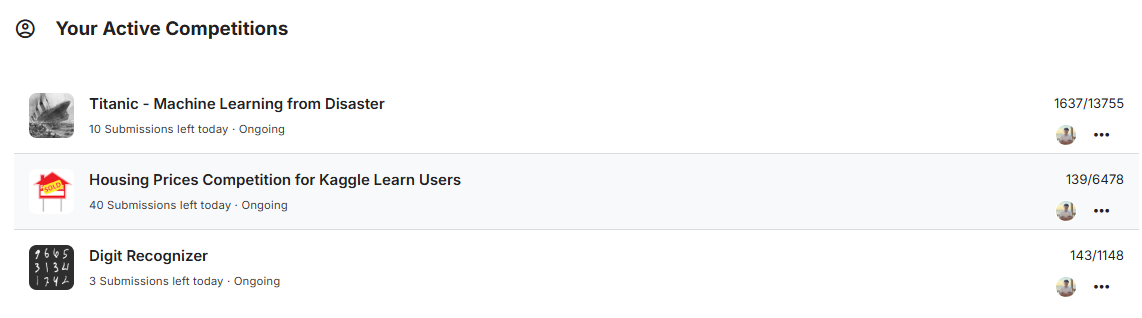

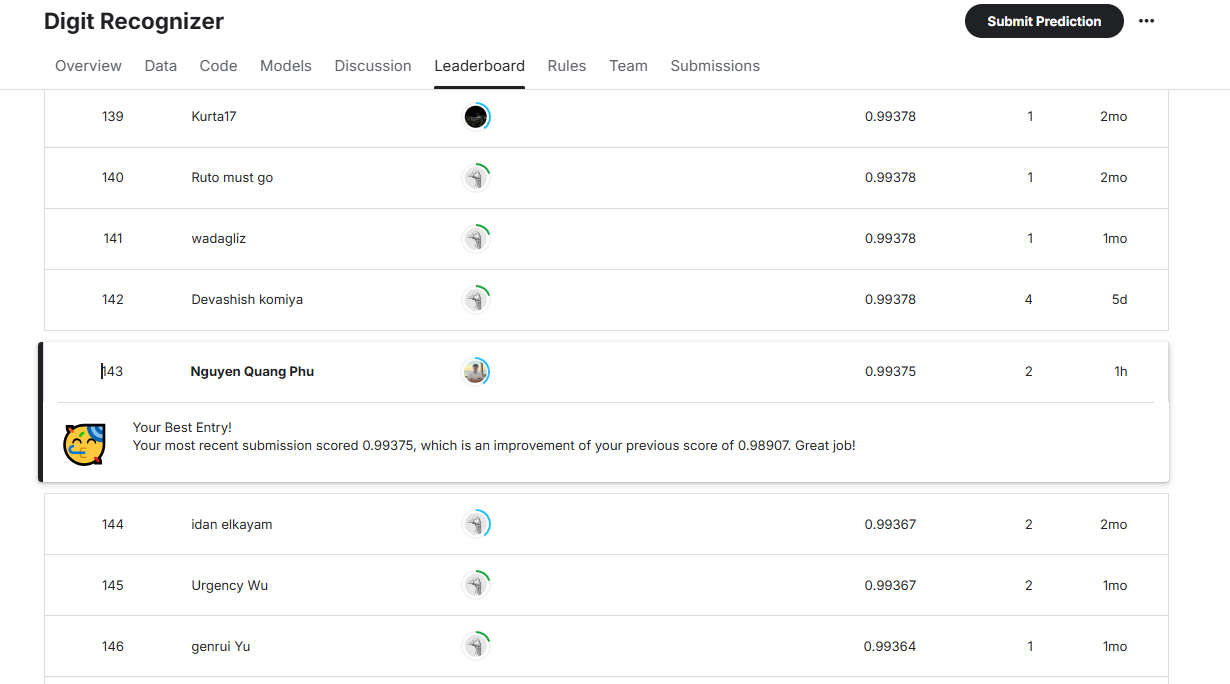

In [ ]:
%pip install pillow requests

from IPython.display import display
from PIL import Image
import requests
from io import BytesIO

# Google Drive direct link: 
image_url = "https://drive.google.com/uc?id=1i5kMBVq4V2xBHZ0a-HIxlwO2VetRifpF"
image_url2 = "https://drive.google.com/uc?id=1X45G3lHPxRVbW8U73x6zertPldXfNSI7"

# Fetch image
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
display(img)

response2 = requests.get(image_url2)
img2 = Image.open(BytesIO(response2.content))
display(img2)


# Download and Import

In [1]:
%pip install torch torchvision matplotlib pandas numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, random_split
import numpy as np
import pandas as pd
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


# Processing

Here I perform something:
- I use your provided code to download and split the data using ```torchvision.datasets``` and ```from torch.utils.data import random_split, DataLoader```
- I also take the dataset (including train and test ones) from the Kaggle Competition called: [Digit Recognizer](https://www.kaggle.com/competitions/digit-recognizer/overview)
- 

In [ ]:
# Define transformations (data augmentation & normalization)
transform = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Data augmentation: randomly rotate 10 degrees and shift images upto 10% width or height
    transforms.ToTensor(),                                      # COnvert PIL image -> Pytorch tensor, scale pixels val from [0, 255] -> [0,1]
    transforms.Normalize((0.1307,), (0.3081,))                  # Normalizes the image using the mean and standard deviation of MNIST
])

# Load Torchvision MNIST dataset (for extra training data)
torchvision_mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Split dataset into training (50K) and validation (10K)
train_size = 50000
val_size = 10000
torchvision_train, torchvision_val = random_split(torchvision_mnist_train, [train_size, val_size])

# LOAD KAGGLE'S TRAIN.CSV PROPERLY 
# Load Kaggle competition dataset
kaggle_train_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")

# Extract labels and pixel values
kaggle_labels = kaggle_train_df["label"].values
kaggle_images = kaggle_train_df.drop(columns=["label"]).values

# Normalize and reshape images to (1, 28, 28)
kaggle_images = (kaggle_images / 255.0).reshape(-1, 1, 28, 28)

# Define custom dataset class for Kaggle data
class KaggleMNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images, dtype=torch.float32)  # Ensure images are float tensors
        self.labels = torch.tensor(labels, dtype=torch.long)  # Ensure labels are long tensors

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], int(self.labels[idx])  # Convert label to int for consistency

# Define the augmentation generator
# Like above when you defined a transform function for the Torchvision MNIST dataset
# But now we create a generator for the competition dataset
datagen = ImageDataGenerator(
    rotation_range=10,      # Rotate images by ±10 degrees
    zoom_range=0.10,        # Zoom in/out by 10%
    width_shift_range=0.1,  # Shift images horizontally by 10%
    height_shift_range=0.1  # Shift images vertically by 10%
)

# Generate augmented images for Kaggle dataset
augmented_images = []
augmented_labels = []

# Convert (1, 28, 28) to (28, 28, 1) for augmentation
original_images = kaggle_images.reshape(-1, 28, 28, 1)

for i in range(len(original_images)):
    img = original_images[i]
    label = kaggle_labels[i]

    # Generate 10 new images per original image
    for _ in range(10):
        augmented_img = datagen.random_transform(img)
        augmented_images.append(augmented_img)
        augmented_labels.append(label)

# Convert back to tensors
augmented_images = np.array(augmented_images).reshape(-1, 1, 28, 28)
augmented_labels = np.array(augmented_labels)

# Create new dataset
augmented_kaggle_dataset = KaggleMNISTDataset(augmented_images, augmented_labels)

# Create Kaggle training dataset
kaggle_train_dataset = KaggleMNISTDataset(kaggle_images, kaggle_labels)

# Merge augmented data with original dataset
# Merge the one you guide us to get + the competition train dataset + generated train dataset from kaggle train dataset
combined_train_dataset = ConcatDataset([torchvision_train, kaggle_train_dataset, augmented_kaggle_dataset])

def custom_collate(batch):
    images, labels = zip(*batch)  # Unzip batch
    images = torch.stack(images)  # Convert list of tensors into a single tensor
    labels = torch.tensor(labels, dtype=torch.long)  # Convert labels into a tensor
    return images, labels

# Create DataLoaders
BATCH_SIZE = 128
train_loader = DataLoader(combined_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True, collate_fn=custom_collate)
val_loader = DataLoader(torchvision_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True, collate_fn=custom_collate)


# ✅ LOAD KAGGLE'S TEST.CSV PROPERLY ✅
# Load Kaggle test dataset
kaggle_test_df = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

# Normalize and reshape images to (1, 28, 28)
kaggle_test_images = (kaggle_test_df.values / 255.0).reshape(-1, 1, 28, 28)

# Define Kaggle Test Dataset class
class KaggleTestDataset(Dataset):
    def __init__(self, images):
        self.images = torch.tensor(images, dtype=torch.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

# Create test dataset (ONLY Kaggle test data)
test_dataset = KaggleTestDataset(kaggle_test_images)

# Define test DataLoader (only Kaggle test data)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# ✅ PRINT DATASET SHAPES TO VERIFY ✅
print(f"✔ Torchvision Training Samples: {len(torchvision_train)}")
print(f"✔ Kaggle Training Samples: {len(kaggle_train_dataset)}")
print(f"✔ Combined Training Samples: {len(combined_train_dataset)}")
print(f"✔ Validation Samples: {len(torchvision_val)}")
print(f"✔ Test Samples (from Kaggle): {len(test_dataset)}")

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 59.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.68MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.62MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

✔ Torchvision Training Samples: 50000
✔ Kaggle Training Samples: 42000
✔ Combined Training Samples: 512000
✔ Validation Samples: 10000
✔ Test Samples (from Kaggle): 28000


# Model

## **Model Overview**
This is a **Multi-Layer Perceptron (MLP)** designed for **image classification** tasks, particularly for datasets like **MNIST** (where each image has 784 input features). It incorporates:
- **Skip Connections**: Helps with gradient flow and reduces vanishing gradients.
- **Dropout**: Prevents overfitting by randomly deactivating neurons during training.
- **Batch Normalization**: Stabilizes training by normalizing activations at each layer.


## **Architecture Details**
| Layer | Details | Purpose |
|--------|---------|---------|
| **Input Layer** | 784-dimensional input (28×28 images) | Flattens the image for processing |
| **Fully Connected (fc1)** | 512 neurons + BatchNorm + ReLU + Dropout | Learns first-level features |
| **Skip Connection** | `input → fc2` | Directly passes input to second hidden layer |
| **Fully Connected (fc2)** | 256 neurons + BatchNorm + ReLU + Dropout | Learns deeper representations, combined with skip connection |
| **Fully Connected (fc3)** | 128 neurons + BatchNorm + ReLU + Dropout | Further feature extraction |
| **Output Layer (fc_out)** | 10 neurons (one per class) | Outputs raw logits for classification |


## **Skip Connection**
- **Traditional MLPs** suffer from vanishing gradients, making it difficult to train deep networks.
- We introduce a **skip connection** that **bypasses** the first hidden layer, allowing the **input to be directly fed into the second hidden layer**.
- This encourages **feature reuse** and improves learning efficiency.

---


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[512, 256, 128], output_size=10, dropout_rate=0.3):
        super(MLP, self).__init__()

        # First hidden layer
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])

        # Second hidden layer with Skip Connection
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
        self.skip = nn.Linear(input_size, hidden_sizes[1])  # Skip connection

        # Third hidden layer
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.bn3 = nn.BatchNorm1d(hidden_sizes[2])

        # Output layer
        self.fc_out = nn.Linear(hidden_sizes[2], output_size)

        # Activation and Regularization
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input

        # First hidden layer
        x1 = self.relu(self.bn1(self.fc1(x)))
        x1 = self.dropout(x1)

        # Second hidden layer with Skip Connection
        x2 = self.relu(self.bn2(self.fc2(x1) + self.skip(x)))
        x2 = self.dropout(x2)

        # Third hidden layer
        x3 = self.relu(self.bn3(self.fc3(x2)))
        x3 = self.dropout(x3)

        # Output layer
        out = self.fc_out(x3)
        return out


Dynamically adjusts the learning rate during training if the model stops improving by using ```ReduceLROnPlateau```

In [ ]:
# Model initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


# Training

- Here we define our 10 MLP models for training multiple instanecs, each will be train for 30 epochs
- We track their performance at each epoch, implement early stopping if the performance not improve for 5 epochs and save the best-performing model for each instance also


In [6]:
# Define 10 models
NUM_MODELS = 10
mlp_models = [MLP().to(device) for _ in range(NUM_MODELS)]

# Training each model separately
EPOCHS = 30  # Reduced epochs for multiple models
best_models = []

for i, model in enumerate(mlp_models):
    print(f"\n🔹 Training Model {i+1}/{NUM_MODELS}...\n")

    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    criterion = nn.CrossEntropyLoss()
    
    best_val_loss = float('inf')
    patience, patience_counter = 5, 0

    for epoch in range(EPOCHS):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()
            inputs = inputs.view(inputs.size(0), -1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()
                inputs = inputs.view(inputs.size(0), -1)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        val_loss /= len(val_loader)

        scheduler.step(val_loss)

        print(f"Model {i+1} | Epoch {epoch+1}/{EPOCHS} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"best_model_{i}.pth")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"🔴 Early stopping for Model {i+1}!\n")
                break

    best_models.append(model)



🔹 Training Model 1/10...

Model 1 | Epoch 1/30 | Train Acc: 91.41% | Val Acc: 94.45%
Model 1 | Epoch 2/30 | Train Acc: 94.94% | Val Acc: 96.30%
Model 1 | Epoch 3/30 | Train Acc: 95.51% | Val Acc: 96.46%
Model 1 | Epoch 4/30 | Train Acc: 95.67% | Val Acc: 96.27%
Model 1 | Epoch 5/30 | Train Acc: 95.79% | Val Acc: 96.01%
Model 1 | Epoch 6/30 | Train Acc: 95.82% | Val Acc: 96.36%
Model 1 | Epoch 7/30 | Train Acc: 96.74% | Val Acc: 97.48%
Model 1 | Epoch 8/30 | Train Acc: 96.82% | Val Acc: 97.43%
Model 1 | Epoch 9/30 | Train Acc: 96.88% | Val Acc: 97.77%
Model 1 | Epoch 10/30 | Train Acc: 96.90% | Val Acc: 97.42%
Model 1 | Epoch 11/30 | Train Acc: 96.87% | Val Acc: 97.60%
Model 1 | Epoch 12/30 | Train Acc: 96.92% | Val Acc: 97.51%
Model 1 | Epoch 13/30 | Train Acc: 96.96% | Val Acc: 97.53%
Model 1 | Epoch 14/30 | Train Acc: 97.49% | Val Acc: 98.14%
Model 1 | Epoch 15/30 | Train Acc: 97.62% | Val Acc: 98.15%
Model 1 | Epoch 16/30 | Train Acc: 97.65% | Val Acc: 98.20%
Model 1 | Epoch 17/30 

# Testing

**🔹 Key Functionalities of Ensemble Prediction Block**

1. **Loads the Best Models**  
   - Each of the **10 trained MLP models** (`NUM_MODELS`) is loaded from disk (`best_model_{i}.pth`).
   - Sets each model to **evaluation mode** (`eval()`) to disable dropout and batch norm updates.

2. **Performs Predictions on Test Data**  
   - Runs **inference on test data** without computing gradients (`torch.no_grad()`).
   - Each model independently predicts class labels.

3. **Applies Majority Voting (Ensemble Method)**  
   - Collects predictions from all 10 models.
   - Uses **statistical mode (`scipy.stats.mode`)** to determine the **most frequent prediction** for each test sample.

4. **Generates Submission File** (`submission.csv`)  
   - Creates a CSV file with predicted labels for submission.
   - Displays the first few predictions (`submission_df.head()`).


In [7]:
import torch.nn.functional as F
from scipy.stats import mode

# Load best models
for i in range(NUM_MODELS):
    mlp_models[i].load_state_dict(torch.load(f"best_model_{i}.pth"))
    mlp_models[i].eval()  # Set to evaluation mode

all_predictions = []

# Make predictions using all models
with torch.no_grad():
    for batch in test_loader:
        if isinstance(batch, (tuple, list)):  
            inputs = batch[0].to(device)
        else:  
            inputs = batch.to(device)
        
        inputs = inputs.view(inputs.size(0), -1)

        # Get predictions from all models
        batch_predictions = []
        for model in mlp_models:
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            batch_predictions.append(preds.cpu().numpy())

        all_predictions.append(np.array(batch_predictions))

# Convert to numpy array
all_predictions = np.concatenate(all_predictions, axis=1)  # Shape: (10, num_samples)

# Majority voting for final prediction
final_predictions = mode(all_predictions, axis=0).mode.squeeze()

# Create submission file
submission_df = pd.DataFrame({"ImageId": np.arange(1, len(final_predictions) + 1), "Label": final_predictions})
submission_df.to_csv("submission.csv", index=False)

print(submission_df.head())
print("🎯 Ensembling complete! Submission file 'submission.csv' generated successfully.")


<ipython-input-7-d78129de2db8>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_models[i].load_state_dict(torch.load(f"best_model_{i}.pth"))


   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      0
4        5      3
🎯 Ensembling complete! Submission file 'submission.csv' generated successfully.
